# SHACL Intro

Ocean Info Hub SHACL validation examples

It should be noted here that SHACL validation is not a service OIH offers.  Rather, 
the validation is a capacity that the OIH architectural approach facilities.  Further
this validation follows W3C recommendations as describted in 
[https://www.w3.org/TR/shacl/](https://www.w3.org/TR/shacl/).

* [SHACL Playground](https://shacl.org/playground/)
* [kglab SHACL validation with pySHACL](https://derwen.ai/docs/kgl/ex5_0/)


## A few imports to support the code following

In [1]:
import kglab as kg
from rdflib import Graph, plugin
from rdflib.serializer import Serializer

## Load out files

The process involves two inputs.  One is the "data graph" which will be the graph we are testing.  The other in the "shape graph" which is the graph containing our validation and constraint logic.  Both of these are RDF based but can be in any serialization.  

Here we have used JSON-LD for the data graph, since that is what people are using to publish structured data on the web at their web sites, so lets stick with that.

For the shape graph, we use Turtle (.ttl) because it's cleaner, compact and a bit more friendly for human reading.  Since this graph is being built by humans for computers, lets cater to the human in that equation.

In [2]:
# set up the files we will use here
# dg = './datagraphs/test_org.json'
dg = './datagraphs/datagraph.json'

# sg = './shapes/oih_spatial1.ttl'
sg = './shapes/oih_learning.ttl'

## Data Graph

We can visualize our data graph and get an idea of what it looks like.   For this exmaple we are looking at the [Schema.org Course](https://schema.org/Course) type.  

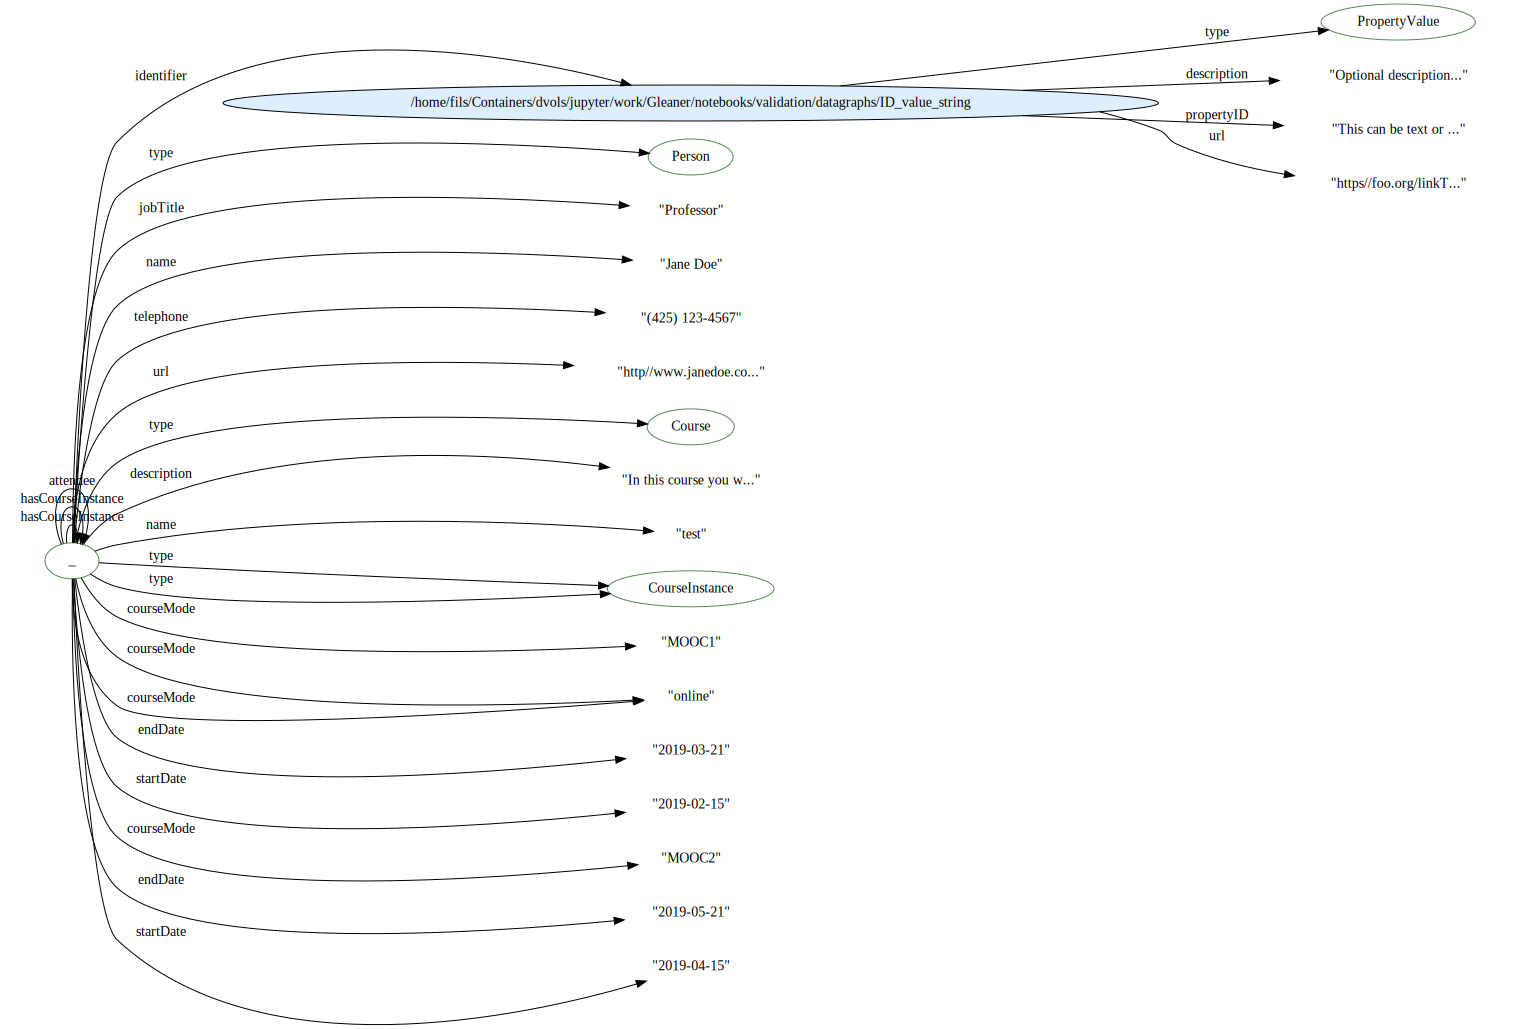

In [3]:
import json
from pyld import jsonld
import os, sys

currentdir = os.path.dirname(os.path.abspath(''))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir)
from lib import jbutils

g = Graph().parse(dg, format='json-ld')

context = {
    "@vocab": "https://schema.org/",
}

jld = g.serialize(format='json-ld', context=context, indent=4)

doc = json.loads(jld)


compacted = jsonld.compact(doc, context)
jbutils.show_graph(compacted)



## Shape graph

Let's use a bit of code to visualize our shape graph.  The nature of shape graph means they don't visualize as well, but we can still get a feel for our graph this way.

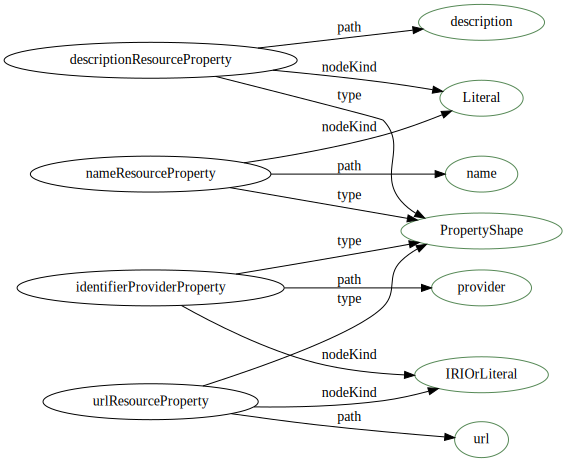

In [4]:
import json
from pyld import jsonld
import os, sys

currentdir = os.path.dirname(os.path.abspath(''))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir)
from lib import jbutils

g = Graph().parse(sg, format='ttl')

context = {"schema": "https://schema.org/", 
           "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
           "shacl": "http://www.w3.org/ns/shacl#" ,
           "oihval": "https://oceans.collaborium.io/voc/validation/1.0.1/shacl#" 
           }

sgjld = g.serialize(format='json-ld', context=context, indent=4)

doc = json.loads(sgjld)

frame = {
  "@context": {"schema": "https://schema.org/", 
           "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
           "shacl": "http://www.w3.org/ns/shacl#" ,
           "oihval": "https://oceans.collaborium.io/voc/validation/1.0.1/shacl#" 
           },
  "@explicit": "true",
  "@requireAll": "true",
  "@type":     {},
  # "shacl:message": "",
  # "shacl:targetClass": "",
  "shacl:path": "",  
  "shacl:nodeKind": "",
}

compacted = jsonld.compact(doc, context)

framed = jsonld.frame(compacted, frame)
jd = json.dumps(framed, indent=4)
# print(jd)

jbutils.show_graph(framed)

In [5]:
# pyshack sends output to log along with the vars.  This suppresses that
import logging, sys
logging.disable(sys.maxsize)

In [6]:
import kglab

namespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

kg = kglab.KnowledgeGraph(
    name = "Schema.org based datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
    )

kg.load_jsonld(dg)

In [7]:
conforms, report_graph, report_text = kg.validate(
    shacl_graph=sg,
    shacl_graph_format="ttl"
)

In [8]:
print(report_text)

Validation Report
Conforms: False
Results (3):
Constraint Violation in NodeKindConstraintComponent (http://www.w3.org/ns/shacl#NodeKindConstraintComponent):
	Severity: shacl:Violation
	Source Shape: oihval:IDShape
	Focus Node: [ :description Literal("In this course you will get an introduction to the main tools and ideas in the data scientist's toolbox...") ; :hasCourseInstance [ :attendee [ :identifier <file:///home/fils/Containers/dvols/jupyter/work/Gleaner/notebooks/validation/ID_value_string> ; :jobTitle Literal("Professor") ; :name Literal("Jane Doe") ; :telephone Literal("(425) 123-4567") ; :url Literal("http://www.janedoe.com") ; rdf:type :Person ] ; :courseMode Literal("MOOC1"), Literal("online") ; :endDate Literal("2019-03-21" = None, datatype=xsd:dateTime) ; :startDate Literal("2019-02-15" = None, datatype=xsd:dateTime) ; rdf:type :CourseInstance ], [ :courseMode Literal("MOOC2"), Literal("online") ; :endDate Literal("2019-05-21" = None, datatype=xsd:dateTime) ; :startDate Li

In [9]:
import pandas as pd
pd.set_option("max_rows", None)
        
sparql = """
SELECT ?path ?value ?constraint ?severity ?message ?id ?focus 
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""

df = report_graph.query_as_df(sparql)
# df.head(10)

In [10]:
def change_color_group(x):
    df = x.copy()
    df.loc[df['severity'] == "shacl:Violation", :] = 'background-color: #F89782'
    df.loc[df['severity'] == "shacl:Warning", :] = 'background-color: #F0F480'
    df.loc[df['severity'] == "shacl:Info", :] = 'background-color: #CBFBD2'
    return df 

In [15]:
pdf = df.to_pandas()
# pdf.style.apply(change_color_group, axis=None)
pdf.head()

,path,constraint,severity,message,id,focus,value
0,:provider,sh:MinCountConstraintComponent,sh:Violation,A provider must be noted,_:n348199a7f8e54b47a42e041d702f4b48b2,_:n348199a7f8e54b47a42e041d702f4b48b3,None
1,:url,sh:MinCountConstraintComponent,sh:Violation,URL required for the location of the resource ...,_:n348199a7f8e54b47a42e041d702f4b48b4,_:n348199a7f8e54b47a42e041d702f4b48b3,None
2,None,sh:NodeKindConstraintComponent,sh:Violation,Graph must have an ID,_:n348199a7f8e54b47a42e041d702f4b48b5,_:n348199a7f8e54b47a42e041d702f4b48b3,_:n348199a7f8e54b47a42e041d702f4b48b3


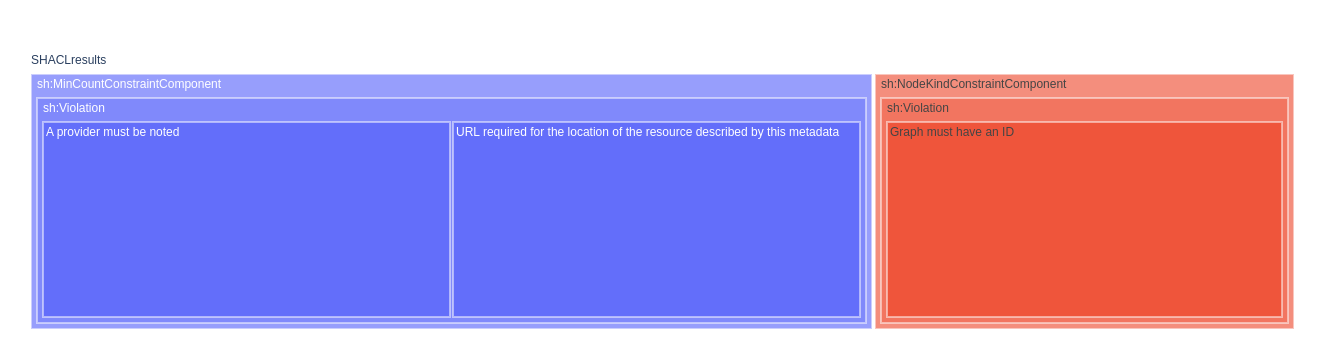

In [13]:
import plotly.express as px

fig = px.treemap(pdf, path=[px.Constant("SHACLresults"), 'constraint', 'severity', 'message'])
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()